In [1]:
# For some reason Theano is unhappy when I run the GP, need to disable future warnings
import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import requests
import pymc3 as pm
import pandas as pd
import numpy as np
import theano
import theano.tensor as tt

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from matplotlib import ticker

from datetime import date
from datetime import datetime

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

In [2]:
def confirmed_to_onset(confirmed, p_delay):

    assert not confirmed.isna().any()
    
    # Reverse cases so that we convolve into the past
    convolved = np.convolve(confirmed[::-1].values, p_delay)

    # Calculate the new date range
    dr = pd.date_range(end=confirmed.index[-1],
                       periods=len(convolved))

    # Flip the values and assign the date range
    onset = pd.Series(np.flip(convolved), index=dr)
    
    return onset

In [3]:
def adjust_onset_for_right_censorship(onset, p_delay):
    cumulative_p_delay = p_delay.cumsum()
    
    # Calculate the additional ones needed so shapes match
    ones_needed = len(onset) - len(cumulative_p_delay)
    padding_shape = (0, ones_needed)
    
    # Add ones and flip back
    cumulative_p_delay = np.pad(
        cumulative_p_delay,
        padding_shape,
        constant_values=1)
    cumulative_p_delay = np.flip(cumulative_p_delay)
    
    # Adjusts observed onset values to expected terminal onset values
    adjusted = onset / cumulative_p_delay
    
    return adjusted, cumulative_p_delay


In [4]:
class MCMCModel(object):
    
    def __init__(self, region, onset, cumulative_p_delay, window=50):
        
        # Just for identification purposes
        self.region = region
        
        # For the model, we'll only look at the last N
        self.onset = onset.iloc[-window:]
        self.cumulative_p_delay = cumulative_p_delay[-window:]
        
        # Where we store the results
        self.trace = None
        self.trace_index = self.onset.index[1:]

    def run(self, chains=1, tune=3000, draws=1000, target_accept=.95):

        with pm.Model() as model:

            # Random walk magnitude
            step_size = pm.HalfNormal('step_size', sigma=.03)

            # Theta random walk
            theta_raw_init = pm.Normal('theta_raw_init', 0.1, 0.1)
            theta_raw_steps = pm.Normal('theta_raw_steps', shape=len(self.onset)-2) * step_size
            theta_raw = tt.concatenate([[theta_raw_init], theta_raw_steps])
            theta = pm.Deterministic('theta', theta_raw.cumsum())

            # Let the serial interval be a random variable and calculate r_t
            serial_interval = pm.Gamma('serial_interval', alpha=6, beta=1.5)
            gamma = 1.0 / serial_interval
            r_t = pm.Deterministic('r_t', theta/gamma + 1)

            inferred_yesterday = self.onset.values[:-1] / self.cumulative_p_delay[:-1]
            
            expected_today = inferred_yesterday * self.cumulative_p_delay[1:] * pm.math.exp(theta)

            # Ensure cases stay above zero for poisson
            mu = pm.math.maximum(.1, expected_today)
            observed = self.onset.round().values[1:]
            cases = pm.Poisson('cases', mu=mu, observed=observed)

            self.trace = pm.sample(
                chains=chains,
                tune=tune,
                draws=draws,
                target_accept=target_accept)
            
            return self
    
    def run_gp(self):
        with pm.Model() as model:
            gp_shape = len(self.onset) - 1

            length_scale = pm.Gamma("length_scale", alpha=3, beta=.4)

            eta = .05
            cov_func = eta**2 * pm.gp.cov.ExpQuad(1, length_scale)

            gp = pm.gp.Latent(mean_func=pm.gp.mean.Constant(c=0), 
                              cov_func=cov_func)

            # Place a GP prior over the function f.
            theta = gp.prior("theta", X=np.arange(gp_shape)[:, None])

            # Let the serial interval be a random variable and calculate r_t
            serial_interval = pm.Gamma('serial_interval', alpha=6, beta=1.5)
            gamma = 1.0 / serial_interval
            r_t = pm.Deterministic('r_t', theta / gamma + 1)

            inferred_yesterday = self.onset.values[:-1] / self.cumulative_p_delay[:-1]
            expected_today = inferred_yesterday * self.cumulative_p_delay[1:] * pm.math.exp(theta)

            # Ensure cases stay above zero for poisson
            mu = pm.math.maximum(.1, expected_today)
            observed = self.onset.round().values[1:]
            cases = pm.Poisson('cases', mu=mu, observed=observed)

            self.trace = pm.sample(chains=1, tune=1000, draws=1000, target_accept=.8)
        return self

In [5]:
def df_from_model(model):
    
    r_t = model.trace['r_t']
    mean = np.mean(r_t, axis=0)
    median = np.median(r_t, axis=0)
    hpd_90 = pm.stats.hpd(r_t, credible_interval=.9)
    hpd_50 = pm.stats.hpd(r_t, credible_interval=.5)
    
    idx = pd.MultiIndex.from_product([
            [model.region],
            model.trace_index
        ], names=['region', 'date'])
        
    df = pd.DataFrame(data=np.c_[mean, median, hpd_90, hpd_50], index=idx,
                 columns=['mean', 'median', 'lower_90', 'upper_90', 'lower_50','upper_50'])
    return df

def create_and_run_model(name, state):
    confirmed = state.positive.diff().dropna()
    onset = confirmed_to_onset(confirmed, p_delay)
    adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset, p_delay)
    return MCMCModel(name, onset, cumulative_p_delay).run()

In [6]:
url = 'https://covidtracking.com/api/v1/states/daily.csv'
states = pd.read_csv(url,
                     parse_dates=['date'],
                     index_col=['state', 'date']).sort_index()

# Note: GU/AS/VI do not have enough data for this model to run
# Note: PR had -384 change recently in total count so unable to model
states = states.drop(['MP', 'GU', 'AS', 'PR', 'VI'])

## SUR
states = {state: grp for state, grp in states.groupby('state')}['CA']
states.head()

positive  negative  pending  hospitalizedCurrently  \
state date                                                             
CA    2020-03-04      53.0     462.0      NaN                    NaN   
      2020-03-05      53.0     462.0      NaN                    NaN   
      2020-03-06      60.0     462.0      NaN                    NaN   
      2020-03-07      69.0     462.0      NaN                    NaN   
      2020-03-08      88.0     462.0      NaN                    NaN   

                  hospitalizedCumulative  inIcuCurrently  inIcuCumulative  \
state date                                                                  
CA    2020-03-04                     NaN             NaN              NaN   
      2020-03-05                     NaN             NaN              NaN   
      2020-03-06                     NaN             NaN              NaN   
      2020-03-07                     NaN             NaN              NaN   
      2020-03-08                     NaN             NaN              NaN   

                  onVentilatorCurrently  onVentilatorCumulative  recovered  \
state date                                                                   
CA    2020-03-04                    NaN                     NaN        NaN   
      2020-03-05                    NaN                     NaN        NaN   
      2020-03-06                    NaN                     NaN        NaN   
      2020-03-07                    NaN                     NaN        NaN   
      2020-03-08                    NaN                     NaN        NaN   

                  ... hospitalized  total  totalTestResults  posNeg  fips  \
state date        ...                                                       
CA    2020-03-04  ...          NaN  515.0             515.0   515.0     6   
      2020-03-05  ...          NaN  515.0             515.0   515.0     6   
      2020-03-06  ...          NaN  522.0             522.0   522.0     6   
      2020-03-07  ...          NaN  531.0             531.0   531.0     6   
      2020-03-08  ...          NaN  550.0             550.0   550.0     6   

                  deathIncrease  hospitalizedIncrease  negativeIncrease  \
state date                                                                
CA    2020-03-04            NaN                   NaN               NaN   
      2020-03-05            0.0                   0.0               0.0   
      2020-03-06            0.0                   0.0               0.0   
      2020-03-07            0.0                   0.0               0.0   
      2020-03-08            0.0                   0.0               0.0   

                  positiveIncrease  totalTestResultsIncrease  
state date                                                    
CA    2020-03-04               NaN                       NaN  
      2020-03-05               0.0                       0.0  
      2020-03-06               7.0                       7.0  
      2020-03-07               9.0                       9.0  
      2020-03-08              19.0                      19.0  

[5 rows x 23 columns]

In [7]:
# Make sure that all the states have current data
today = datetime.combine(date.today(), datetime.min.time())
last_updated = states.reset_index('date').groupby('state')['date'].max()
is_current = last_updated < today

try:
    assert is_current.sum() == 0
except AssertionError:
    print("Not all states have updated")
    display(last_updated[is_current])

# Ensure all case diffs are greater than zero
for state, grp in states.groupby('state'):
    new_cases = grp.positive.diff().dropna()
    is_positive = new_cases.ge(0)
    
    try:
        assert is_positive.all()
    except AssertionError:
        print(f"Warning: {state} has date with negative case counts")
        display(new_cases[~is_positive])
        
# Let's make sure that states have added cases
idx = pd.IndexSlice
assert not states.loc[idx[:, '2020-04-22':'2020-04-23'], 'positive'].groupby('state').diff().dropna().eq(0).any()

In [8]:
# Load the patient CSV
patients = pd.read_csv(
    '../../COVID-20/data/linelist.csv',
    parse_dates=False,
    usecols=[
        'date_confirmation',
        'date_onset_symptoms'],
    low_memory=False)

patients.columns = ['Onset', 'Confirmed']

# There's an errant reversed date
patients = patients.replace('01.31.2020', '31.01.2020')

# Only keep if both values are present
patients = patients.dropna()

# Must have strings that look like individual dates
# "2020.03.09" is 10 chars long
is_ten_char = lambda x: x.str.len().eq(10)
patients = patients[is_ten_char(patients.Confirmed) & 
                    is_ten_char(patients.Onset)]

# Convert both to datetimes
patients.Confirmed = pd.to_datetime(
    patients.Confirmed, format='%d.%m.%Y')
patients.Onset = pd.to_datetime(
    patients.Onset, format='%d.%m.%Y')

# Only keep records where confirmed > onset
patients = patients[patients.Confirmed >= patients.Onset]

## SUR
patients.head()

,Onset,Confirmed
53,2020-02-08,2020-02-14
55,2020-02-01,2020-02-13
335,2020-01-30,2020-02-14
365,2020-02-14,2020-02-16
446,2020-02-11,2020-02-15


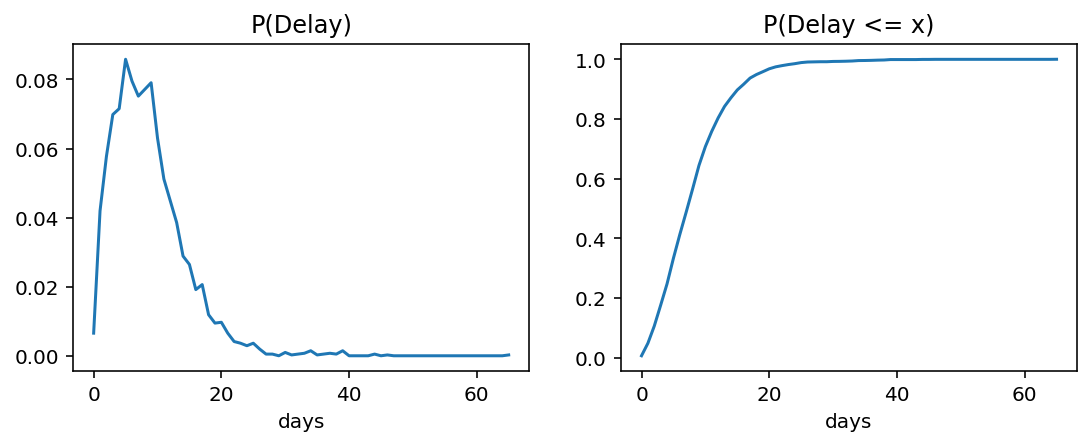

In [9]:
# Calculate the delta in days between onset and confirmation
delay = (patients.Confirmed - patients.Onset).dt.days

# Convert samples to an empirical distribution
p_delay = delay.value_counts().sort_index()
new_range = np.arange(0, p_delay.index.max()+1)
p_delay = p_delay.reindex(new_range, fill_value=0)
p_delay /= p_delay.sum()

# Show our work
fig, axes = plt.subplots(ncols=2, figsize=(9,3))
p_delay.plot(title='P(Delay)', ax=axes[0])
p_delay.cumsum().plot(title='P(Delay <= x)', ax=axes[1])
for ax in axes:
    ax.set_xlabel('days')

In [10]:
# state = 'CA'
# confirmed = states.xs(state).positive.diff().dropna()
# onset = confirmed_to_onset(confirmed, p_delay)
# ## SUR
# onset.head()

In [11]:
# adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset, p_delay)

# ## SUR
# print(adjusted.head())
# cumulative_p_delay

In [12]:
models = {}

for state, grp in states.groupby('state'):
    
    print(state)
    
    if state in models:
        print(f'Skipping {state}, already in cache')
        continue
    
    models[state] = create_and_rbun_model(state, grp.droplevel(0))

CA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:48<00:00, 83.31it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [32]:
name = 'CA'
confirmed = states.positive.diff().dropna()
# confirmed = state.positive.diff().dropna()
confirmed = confirmed.droplevel(0)
# confirmed
onset = confirmed_to_onset(confirmed, p_delay)
# confirmed_to_onset(confirmed, p_delay)
adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset, p_delay)
# adjust_onset_for_right_censorship(onset, p_delay)
m1 = MCMCModel(name, onset, cumulative_p_delay).run()
m1

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:48<00:00, 83.24it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [36]:
df_from_model(m1).head()

mean    median  lower_90  upper_90  lower_50  upper_50
region date                                                                  
CA     2020-03-08  1.535545  1.492702  1.158645  1.902491  1.271756  1.572354
       2020-03-09  1.534509  1.492746  1.149638  1.870885  1.314406  1.609936
       2020-03-10  1.528463  1.488808  1.148015  1.870554  1.255176  1.542630
       2020-03-11  1.522192  1.483757  1.142836  1.844095  1.279420  1.561979
       2020-03-12  1.512564  1.472055  1.178507  1.856776  1.284317  1.560226

In [39]:
serie_sintomas = "../../datos/datos_abiertos/serie_tiempo_nacional_confirmados.csv"
serie_confirmacion = "../../datos/datos_abiertos/serie_tiempo_nacional_fecha_confirmacion.csv"


In [100]:
Dat_sintomas = pd.read_csv(serie_sintomas)
Dat_sintomas.head()
Dat_confirmacion = pd.read_csv(serie_confirmacion)
Dat_confirmacion.head()
Dat_sintomas = Dat_sintomas[['fecha', 'sintomas_acumulados']]
Dat_confirmacion = Dat_confirmacion[['fecha', 'casos_acumulados']]

In [119]:
Dat = pd.concat([Dat_sintomas.set_index('fecha'), Dat_confirmacion.set_index('fecha')], axis=1, sort=False).reset_index(col_fill = 'fecha')
Dat.columns = ['fecha', 'sintomas_acumulados', 'casos_acumulados']
Dat = Dat.fillna(0)
Dat['dif'] = Dat.sintomas_acumulados - Dat.casos_acumulados
Dat.fecha = pd.to_datetime(Dat.fecha)
Dat

,fecha,sintomas_acumulados,casos_acumulados,dif
0,2020-01-06,1,0.0,1.0
1,2020-01-07,1,0.0,1.0
2,2020-01-08,2,0.0,2.0
3,2020-01-09,2,0.0,2.0
4,2020-01-10,2,0.0,2.0
...,...,...,...,...
105,2020-04-20,12762,8772.0,3990.0
106,2020-04-21,12827,9501.0,3326.0
107,2020-04-22,12863,10544.0,2319.0
108,2020-04-23,12872,11633.0,1239.0


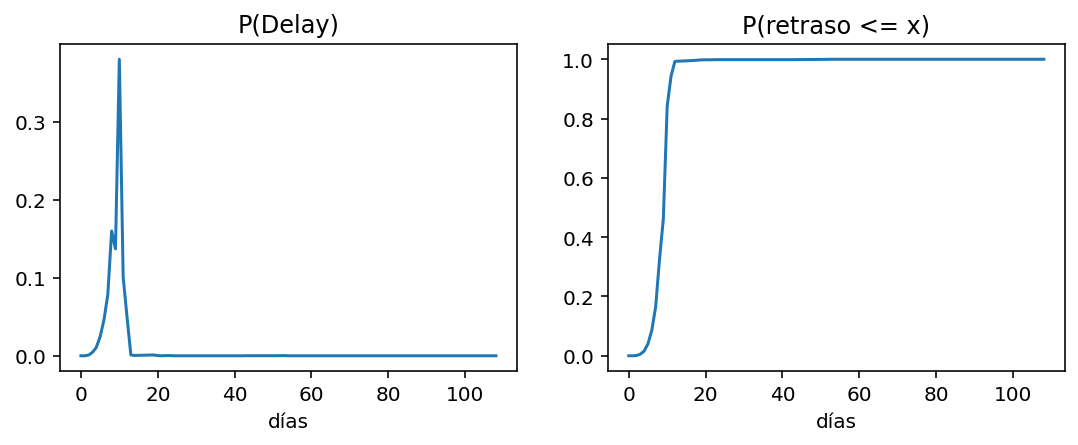

In [146]:
dias = (pd.Series(max(Dat.fecha)) - pd.Series(min(Dat.fecha))).dt.days[0]
p_retraso = pd.Series(np.zeros(dias))
for i, fila in Dat.iterrows():
    for j in range(i, Dat.shape[0]):
        # print(i, j)
        if Dat.casos_acumulados[j] >= Dat.sintomas_acumulados[i]:
            # print("hola")
            p_retraso[j - i] = p_retraso[j - i] + abs(Dat.sintomas_acumulados[i] - Dat.casos_acumulados[j])
            break

        
    

# p_retraso.sum()
p_retraso = p_retraso / p_retraso.sum()
# print(p_retraso.to_string())

# Show our work
fig, axes = plt.subplots(ncols=2, figsize=(9,3))
p_retraso.plot(title='P(Delay)', ax=axes[0])
p_retraso.cumsum().plot(title='P(retraso <= x)', ax=axes[1])
for ax in axes:
    ax.set_xlabel('días')

In [115]:
pd.Series?

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
104    0.0
105    0.0
106    0.0
107    0.0
108    0.0
Length: 109, dtype: float64

In [134]:
# delay = (patients.Confirmed - patients.Onset).dt.days




109

In [78]:
pd.to_datetime("2020-04-24", format = "%Y-%m-%d") - pd.to_datetime("2020-01-06", format = "%Y-%m-%d")

Timedelta('109 days 00:00:00')

0     0.006547
1     0.041950
2     0.057711
3     0.069835
4     0.071532
        ...   
61    0.000000
62    0.000000
63    0.000000
64    0.000000
65    0.000242
Length: 66, dtype: float64